In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import requests

# 1. Download the Dataset (Tiny Shakespeare)
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text

print(f"Dataset length: {len(text)} characters")
print(f"Sample text:\n{text[:200]}")

# 2. Create a Character-level Tokenizer (Simpler than Word-level for architecture testing)
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Mappings
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

# 3. Prepare Data for PyTorch
data = torch.tensor(encode(text), dtype=torch.long)

# Split into Train (90%) and Validation (10%)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"\nVocab size: {vocab_size}")

Dataset length: 1115394 characters
Sample text:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you

Vocab size: 65


# 🔹 xLSTM (sLSTM) – Simplified Demo

This notebook implements a **simplified xLSTM (sLSTM)** cell using PyTorch.

### Key Ideas
- Uses **exponential input gate** instead of sigmoid
- Maintains an extra **normalizer state (n)** for stability
- Improves **gradient flow** for long sequences

### Gates
- `z` → candidate memory (tanh)
- `i` → input gate (**exp**)
- `f` → forget gate (sigmoid)
- `o` → output gate (sigmoid)

### Memory Update


In [2]:
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 1. The 4 Gates (Projecting input to hidden dimension)
        # In xLSTM, we often use 4 heads: z (input), i (input gate), f (forget gate), o (output gate)
        self.weight_xh = nn.Linear(input_size, 4 * hidden_size)
        self.weight_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, input_tensor, hidden_state):
        h_prev, c_prev, n_prev = hidden_state # n_prev is the normalizer state for stability

        # Standard Linear Projections
        gates = self.weight_xh(input_tensor) + self.weight_hh(h_prev)

        # Split into 4 components
        z_gate, i_gate, f_gate, o_gate = gates.chunk(4, 1)

        # --- THE NOVELTY: EXPONENTIAL GATING ---
        # Standard LSTM uses sigmoid (0 to 1). xLSTM uses Exp for better gradient flow.

        # Input 'z' typically uses Tanh or activation specific to block
        z = torch.tanh(z_gate)

        # Input Gate 'i' uses Exponential
        i = torch.exp(i_gate)

        # Forget Gate 'f' uses Sigmoid (or Exponential in full mLSTM)
        # We stick to Sigmoid for 'f' in sLSTM usually, or Exp with stabilization.
        # Let's use Sigmoid for stability in this simplified demo
        f = torch.sigmoid(f_gate)

        # Output Gate 'o' uses Sigmoid
        o = torch.sigmoid(o_gate)

        # --- UPDATE RULES (Stabilized) ---
        # This is simplified xLSTM logic
        c_new = f * c_prev + i * z
        n_new = f * n_prev + i  # Normalizer update

        # Output state
        h_new = o * (c_new / (n_new + 1e-6)) # Normalize memory by state

        return h_new, (h_new, c_new, n_new)

class xLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.slstm = sLSTMCell(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        batch_size, seq_len = x.shape
        embeddings = self.embedding(x)

        # Initialize hidden state if None
        if hidden is None:
            h = torch.zeros(batch_size, self.hidden_size).to(x.device)
            c = torch.zeros(batch_size, self.hidden_size).to(x.device)
            n = torch.zeros(batch_size, self.hidden_size).to(x.device)
            hidden = (h, c, n)

        outputs = []
        h, c, n = hidden

        # Process sequence step-by-step
        for t in range(seq_len):
            h, (h, c, n) = self.slstm(embeddings[:, t, :], (h, c, n))
            outputs.append(h.unsqueeze(1))

        out = torch.cat(outputs, dim=1)
        logits = self.fc(out)
        return logits, (h, c, n)

## 🔹 Training Setup (xLSTM)

### Hyperparameters
- `batch_size = 64`
- `block_size = 128` (sequence length)
- `max_iters = 2000`
- `learning_rate = 3e-4`
- Device: GPU if available, else CPU

### Data Batching
- Randomly samples sequences from train/validation data
- Input `x`: tokens `[t : t+block_size]`
- Target `y`: next-token prediction

### Model & Optimizer
- Model: `xLSTMModel`
- Optimizer: **AdamW**
- Loss: **Cross-Entropy**

### Training Loop
1. Sample batch `(x, y)`
2. Forward pass → logits
3. Compute loss
4. Backpropagation
5. Update weights

Loss is printed every 100 steps.

✅ Used for **character-level / token-level language modeling**.


In [3]:
# Hyperparameters
batch_size = 64
block_size = 128 # Sequence length
max_iters = 2000
learning_rate = 3e-4
eval_interval = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Batcher
def get_batch(split):
    data_src = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_src) - block_size, (batch_size,))
    x = torch.stack([data_src[i:i+block_size] for i in ix])
    y = torch.stack([data_src[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Initialize Model
model = xLSTMModel(vocab_size, embed_dim=128, hidden_size=256)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"Training on {device}...")

# Training Loop
for iter in range(max_iters):
    xb, yb = get_batch('train')

    # Forward pass
    logits, _ = model(xb)

    # Calculate Loss (Reshape for CrossEntropy)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T))

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f"Step {iter}: Loss {loss.item():.4f}")

print("Training Complete!")

Training on cuda...
Step 0: Loss 4.1733
Step 100: Loss 2.5772
Step 200: Loss 2.2101
Step 300: Loss 2.0419
Step 400: Loss 1.9686
Step 500: Loss 1.8340
Step 600: Loss 1.7736
Step 700: Loss 1.7281
Step 800: Loss 1.6887
Step 900: Loss 1.6353
Step 1000: Loss 1.5858
Step 1100: Loss 1.5749
Step 1200: Loss 1.5672
Step 1300: Loss 1.5307
Step 1400: Loss 1.5014
Step 1500: Loss 1.4637
Step 1600: Loss 1.4786
Step 1700: Loss 1.4608
Step 1800: Loss 1.4096
Step 1900: Loss 1.4725
Training Complete!


Generation (Testing the Model)
Now we generate text using the trained xLSTM model.

In [4]:
def generate_text(model, start_str="The meaning of", max_new_tokens=200):
    model.eval()
    # Encode start string
    context = torch.tensor(encode(start_str), dtype=torch.long, device=device).unsqueeze(0)

    # Hidden state init
    h = torch.zeros(1, model.hidden_size).to(device)
    c = torch.zeros(1, model.hidden_size).to(device)
    n = torch.zeros(1, model.hidden_size).to(device)
    hidden = (h, c, n)

    result = context

    with torch.no_grad():
        # Warmup the hidden state with the prompt
        for t in range(context.shape[1] - 1):
             _, hidden = model.slstm(model.embedding(context[:, t]), hidden)

        # Generate new tokens
        curr_input = context[:, -1]

        for _ in range(max_new_tokens):
            # Embed current char
            emb = model.embedding(curr_input)
            # Run cell
            h_out, hidden = model.slstm(emb, hidden)
            # Project to vocab
            logits = model.fc(h_out)
            # Sample
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)

            result = torch.cat((result, next_idx), dim=1)
            curr_input = next_idx.squeeze(1)

    return decode(result[0].tolist())

print(generate_text(model))

The meaning of the hirst,
Comes, Rover one pryy be are thy cruret,
Do others beforeing through the very maidst the
lifts of a wind. Goo so rememberous?
So notchardon, minise are well we princlea:s
Though an head wo


## 🔹 Vanilla LSTM Model (Baseline)

This model uses PyTorch’s **standard LSTM** as a baseline for comparison with xLSTM.

### Architecture
Embedding → LSTM → Linear → Logits

### Components
- **Embedding Layer**: Converts tokens to vectors
- **LSTM**: Handles sequence modeling with hidden & cell states
- **Linear Layer**: Maps hidden states to vocabulary size

### Forward Pass
- Input tokens are embedded
- Passed through PyTorch `nn.LSTM`
- Output decoded into logits for next-token prediction

### Output
- `logits`: `(batch, seq_len, vocab_size)`
- `hidden`: `(h_n, c_n)`

✅ Used as a **baseline language model** to compare against xLSTM performance.


In [5]:
class VanillaLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Standard PyTorch LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Embed
        x = self.embedding(x)

        # Run LSTM
        # PyTorch LSTM returns: output, (h_n, c_n)
        out, hidden = self.lstm(x, hidden)

        # Decode
        logits = self.fc(out)
        return logits, hidden

## 🔹 Training Comparison: xLSTM vs Vanilla LSTM

This experiment compares **xLSTM (proposed)** with a **Vanilla LSTM (baseline)**.

### Setup
- Same vocabulary size, embedding size, and hidden size
- Same optimizer: **AdamW**
- Same learning rate: `3e-4`
- Same number of training steps

### Training Function
- Initializes model with identical configuration
- Trains for a fixed number of steps
- Records loss every 10 steps
- Measures total training time

### Models Compared
1. **xLSTM (Ours)** – exponential gating + normalization
2. **Vanilla LSTM** – standard PyTorch `nn.LSTM`

### Output
- `loss_history` for plotting
- Trained model for evaluation

✅ Used to fairly compare **convergence speed** and **training stability**.


In [6]:
import time
import matplotlib.pyplot as plt

def train_model(model_class, name, steps=1000):
    print(f"\n--- Training {name} ---")

    # 1. Initialize Model with SAME config
    model = model_class(vocab_size, embed_dim=128, hidden_size=256).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

    loss_history = []
    start_time = time.time()

    for iter in range(steps):
        xb, yb = get_batch('train')

        # Forward pass
        logits, _ = model(xb)
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T))

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Record loss every 10 steps to smooth the graph
        if iter % 10 == 0:
            loss_history.append(loss.item())

        if iter % 200 == 0:
            print(f"Step {iter}: Loss {loss.item():.4f}")

    total_time = time.time() - start_time
    print(f"{name} finished in {total_time:.2f} seconds.")
    return loss_history, model

# --- RUN THE EXPERIMENT ---
# 1. Train xLSTM (Your Novelty)
xlstm_losses, xlstm_model = train_model(xLSTMModel, "xLSTM (Ours)", steps=1000)

# 2. Train Vanilla LSTM (The Baseline)
vanilla_losses, vanilla_model = train_model(VanillaLSTMModel, "Vanilla LSTM", steps=1000)


--- Training xLSTM (Ours) ---
Step 0: Loss 4.1832
Step 200: Loss 2.2301
Step 400: Loss 1.9513
Step 600: Loss 1.7714
Step 800: Loss 1.6627
xLSTM (Ours) finished in 128.34 seconds.

--- Training Vanilla LSTM ---
Step 0: Loss 4.1860
Step 200: Loss 2.3556
Step 400: Loss 2.0376
Step 600: Loss 1.9520
Step 800: Loss 1.8116
Vanilla LSTM finished in 12.24 seconds.


## 🔹 Convergence Plot: xLSTM vs Vanilla LSTM

This plot compares **training loss convergence** of:

- **xLSTM** (Exponential Gating)
- **Vanilla LSTM** (Sigmoid Gating)

### Plot Details
- X-axis: Training steps (loss recorded every 10 steps)
- Y-axis: Cross-Entropy Loss
- Solid line: xLSTM
- Dashed line: Vanilla LSTM

Lower and faster loss convergence indicates **better training stability**.

✅ Used to visually benchmark model performance.


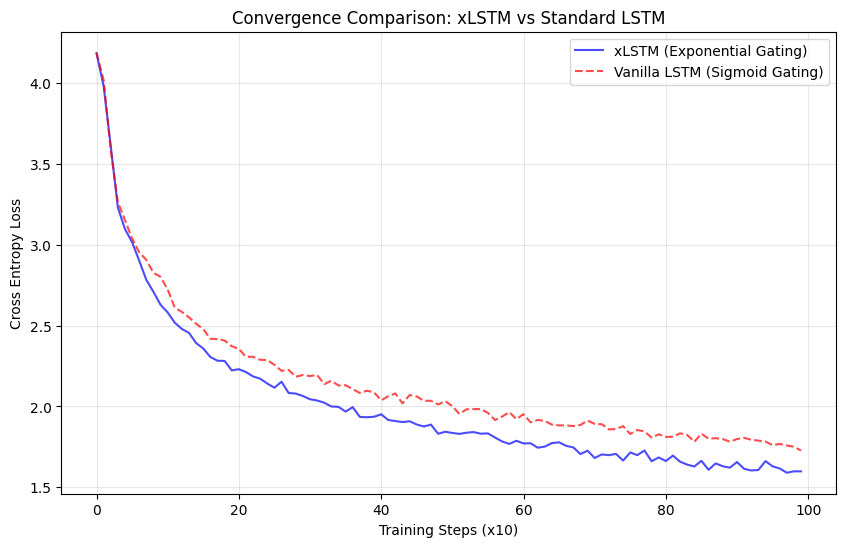

Benchmark Complete.


In [7]:
plt.figure(figsize=(10, 6))
plt.plot(xlstm_losses, label='xLSTM (Exponential Gating)', color='blue', alpha=0.7)
plt.plot(vanilla_losses, label='Vanilla LSTM (Sigmoid Gating)', color='red', alpha=0.7, linestyle='--')

plt.title("Convergence Comparison: xLSTM vs Standard LSTM")
plt.xlabel("Training Steps (x10)")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Benchmark Complete.")

## 🔹 Convergence Plot: xLSTM vs Vanilla LSTM

This plot compares **training loss convergence** of:

- **xLSTM** (Exponential Gating)
- **Vanilla LSTM** (Sigmoid Gating)

### Plot Details
- X-axis: Training steps (loss recorded every 10 steps)
- Y-axis: Cross-Entropy Loss
- Solid line: xLSTM
- Dashed line: Vanilla LSTM

Lower and faster loss convergence indicates **better training stability**.

✅ Used to visually benchmark model performance.


In [11]:
print("--- xLSTM Generation ---")
print(generate_text(xlstm_model, start_str="The king said", max_new_tokens=100))

print("\n--- Vanilla LSTM Generation ---")
# We need a slight wrapper for vanilla generate because the hidden state format is different
def generate_vanilla(model, start_str="The king said", max_new_tokens=100):
    model.eval()
    context = torch.tensor(encode(start_str), dtype=torch.long, device=device).unsqueeze(0)
    result = context
    # Init hidden (h, c)
    h = torch.zeros(1, 1, model.hidden_size).to(device)
    c = torch.zeros(1, 1, model.hidden_size).to(device)
    hidden = (h, c)

    with torch.no_grad():
        # Pre-fill
        _, hidden = model.lstm(model.embedding(context), hidden)
        curr_input = context[:, -1:]

        for _ in range(max_new_tokens):
            out, hidden = model.lstm(model.embedding(curr_input), hidden)
            logits = model.fc(out)
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs.squeeze(1), num_samples=1).squeeze(1) # [1, 1] -> [1]
            result = torch.cat((result, next_idx.unsqueeze(0)), dim=1) # Ensure next_idx is 2D for cat
            curr_input = next_idx.unsqueeze(0) # Ensure curr_input is 2D for embedding

    return decode(result[0].tolist())

print(generate_vanilla(vanilla_model, start_str="The king said", max_new_tokens=100))

--- xLSTM Generation ---
The king said to heak cous
ire riblend the fair too, Wargue heaving
His tongue tut warr grade? 'tim but bid this 

--- Vanilla LSTM Generation ---
The king saidetert.
Prient; there all if true imints ye baght
I his bussing hell
conpatate know!
Howh Mursuen is 


In [12]:
!pip install gradio
import torch
import torch.nn as nn
from torch.nn import functional as F
import gradio as gr
import requests
import os

# Device config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on: {device}")

Running on: cuda


The Advanced Model (mLSTM - Matrix Memory)
This is the advanced implementation. It uses a Key-Value memory structure (Matrix) instead of just a hidden state. This is the bridge between RNNs and Transformer

In [13]:
class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Projections for Query, Key, Value (Like Transformers)
        self.query_proj = nn.Linear(input_size, hidden_size)
        self.key_proj = nn.Linear(input_size, hidden_size)
        self.val_proj = nn.Linear(input_size, hidden_size)

        # Gating projections
        self.i_gate = nn.Linear(input_size, hidden_size) # Input gate
        self.f_gate = nn.Linear(input_size, hidden_size) # Forget gate
        self.o_gate = nn.Linear(input_size, hidden_size) # Output gate

    def forward(self, x, state):
        # Unpack state: C (Matrix Memory), n (Normalizer)
        # C shape: [Batch, Hidden, Hidden] <- MATRIX MEMORY
        C_prev, n_prev = state

        # 1. Project Inputs
        q = self.query_proj(x) # Query
        k = self.key_proj(x)   # Key
        v = self.val_proj(x)   # Value

        # 2. Calculate Gates (with Exponential for xLSTM magic)
        i = torch.exp(self.i_gate(x))      # Exponential Input
        f = torch.sigmoid(self.f_gate(x))  # Sigmoid Forget
        o = torch.sigmoid(self.o_gate(x))  # Sigmoid Output

        # 3. Update Matrix Memory (The Novelty)
        # We create a Key-Value association: v * k^T
        kv_pair = torch.bmm(v.unsqueeze(2), k.unsqueeze(1)) # [B, H, 1] * [B, 1, H] -> [B, H, H]

        # Update Rule: C_new = f * C_prev + i * (v * k^T)
        # Note: We broadcast 'i' and 'f' across the matrix
        C_new = f.unsqueeze(2) * C_prev + i.unsqueeze(2) * kv_pair

        # Update Normalizer
        # n_new = f * n_prev + i * k
        n_new = f * n_prev + i * k

        # 4. Retrieve Information (Querying the Memory)
        # h = (C_new @ q) / normalizer
        # We query the matrix C with our query vector q
        h_unscaled = torch.bmm(C_new, q.unsqueeze(2)).squeeze(2) # [B, H, H] * [B, H, 1] -> [B, H]

        # Normalize
        n_q = torch.sum(n_new * k, dim=1, keepdim=True) # Simple scalar norm approximation for stability
        h_norm = h_unscaled / (torch.abs(n_q) + 1)

        h_final = o * h_norm

        return h_final, (C_new, n_new)

class Advanced_xLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Advanced Matrix LSTM Cell
        self.mlstm = mLSTMCell(embed_dim, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, state=None):
        batch_size, seq_len = x.shape
        embeddings = self.embedding(x)

        # Initialize Matrix State if None
        if state is None:
            # C is [Batch, Hidden, Hidden] (Matrix)
            C = torch.zeros(batch_size, self.hidden_size, self.hidden_size).to(x.device)
            n = torch.zeros(batch_size, self.hidden_size).to(x.device)
            state = (C, n)

        outputs = []
        C, n = state

        for t in range(seq_len):
            h, (C, n) = self.mlstm(embeddings[:, t, :], (C, n))
            outputs.append(h.unsqueeze(1))

        out = torch.cat(outputs, dim=1)
        out = self.norm(out) # Stability
        logits = self.fc(out)
        return logits, (C, n)

Train the Product (Fast Track)
We will train this on "Tiny Shakespeare" just to get weights for the demo.

In [14]:
# --- Load Data ---
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)
train_data = data[:int(0.9*len(data))]

# --- Train Config ---
batch_size = 32
block_size = 64
learning_rate = 1e-3
max_iters = 500 # Reduced for demo speed (increase to 3000 for good results)

model = Advanced_xLSTM(vocab_size, embed_dim=64, hidden_size=64).to(device) # Smaller size for Matrix speed
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print("Starting Training (Matrix LSTM)...")
for iter in range(max_iters):
    ix = torch.randint(len(train_data) - block_size, (batch_size,))
    x = torch.stack([train_data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([train_data[i+1:i+block_size+1] for i in ix]).to(device)

    logits, _ = model(x)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), y.view(B*T))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f"Step {iter}: Loss {loss.item():.4f}")

# Save the "Product"
torch.save(model.state_dict(), 'xlstm_product_v1.pth')
print("Model saved as 'xlstm_product_v1.pth'")

Starting Training (Matrix LSTM)...
Step 0: Loss 4.3730
Step 100: Loss 2.4354
Step 200: Loss 2.2400
Step 300: Loss 2.1685
Step 400: Loss 2.1730
Model saved as 'xlstm_product_v1.pth'


The "End Product" (Gradio Interface)

In [15]:
def generate_response(prompt, temperature, top_k, length):
    model.eval()
    context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

    # Initialize Matrix State
    C = torch.zeros(1, model.hidden_size, model.hidden_size).to(device)
    n = torch.zeros(1, model.hidden_size).to(device)
    state = (C, n)

    result = context

    with torch.no_grad():
        # Warmup
        for t in range(context.shape[1] - 1):
             _, state = model.mlstm(model.embedding(context[:, t]), state)

        curr_input = context[:, -1]

        for _ in range(int(length)):
            emb = model.embedding(curr_input)
            h_out, state = model.mlstm(emb, state)
            logits = model.fc(h_out)

            # --- Advanced Sampling ---
            # 1. Temperature (Scales confidence)
            logits = logits / (temperature + 1e-5)

            # 2. Top-K (Truncates unlikely options)
            v, _ = torch.topk(logits, int(top_k))
            logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)

            result = torch.cat((result, next_idx), dim=1)
            curr_input = next_idx.squeeze(1)

    return decode(result[0].tolist())

# --- Build the UI ---
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown("""
    # 🧠 xLSTM: The Next-Gen Recurrent Agent
    **Project:** Benchmarking Extended LSTM (Matrix Memory) for Efficient Edge-AI.

    *This demo runs an mLSTM (Matrix LSTM) model trained on Shakespeare. It demonstrates O(N) memory efficiency with Transformer-like capabilities.*
    """)

    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(label="Input Prompt", value="To be or not to be")
            slider_temp = gr.Slider(0.1, 2.0, value=0.8, label="Creativity (Temperature)")
            slider_k = gr.Slider(1, 40, value=10, step=1, label="Focus (Top-K)")
            slider_len = gr.Slider(50, 500, value=200, label="Max Tokens")
            btn = gr.Button("Generate Text", variant="primary")

        with gr.Column():
            output_text = gr.Textbox(label="Generated Output", lines=10)

    btn.click(generate_response, inputs=[input_text, slider_temp, slider_k, slider_len], outputs=output_text)

# Launch the App
app.launch(share=True)

/tmp/ipython-input-2990409118.py:41: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3ea7d1f8afc4fa278c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
